## Step 1: Dataset Initialization and Structural Overview

- We begin by loading the dataset and conducting a preliminary structural assessment.
- This includes reviewing the overall shape (i.e., number of rows and columns), inspecting column names, and identifying data types.
- These initial checks help establish a foundational understanding of the dataset and guide subsequent cleaning and analysis steps.


In [64]:
# Load the dataset

import pandas as pd
df = pd.read_excel("../data/1. original-purchase-order-items.xlsx", sheet_name="Query Result Feb 20 2025")

In [65]:
# Peek at first rows

df.head()

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID,Project ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN


In [66]:
# Check shape 

df.shape

(3150, 11)

In [67]:
# Check info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         2910 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3085 non-null   float64
 10  Project ID         0 non-null      float64
dtypes: float64(6), int64(3), object(2)
memory usage: 270.8+ KB


In [68]:
# check null values for each column

df.isna().sum()

Item ID                 0
Item Name             240
Quantity                0
Total Bcy               0
Sub Total Bcy           0
Purchase Order ID       0
Product ID            240
Currency Code           0
Account ID              0
Tax ID                 65
Project ID           3150
dtype: int64

---
## Step2: Column Review: 'Total Bcy' vs 'Sub Total Bcy'

Upon initial inspection, the columns `Total Bcy` and `Sub Total Bcy` appeared nearly identical. A full row-wise comparison revealed that approximately 15 rows contain slight discrepancies between the two values—likely attributable to additional charges such as taxes or fees.

Given our objective to reflect actual spend, we selected `Total Bcy` as the primary measure for downstream analysis. This choice ensures consistency and aligns with business logic prioritizing final billed amounts over pre-tax subtotals.


In [69]:
# Check if Total Bcy and Sub Total Bcy are truly identical 

(df["Total Bcy"] == df["Sub Total Bcy"]).all()

False

In [70]:
diff = df[df["Total Bcy"] != df["Sub Total Bcy"]][["Item Name","Quantity","Total Bcy","Sub Total Bcy"]]

print(diff.head(20))

    Item Name  Quantity  Total Bcy  Sub Total Bcy
218       NaN       2.0     395.22         403.29
219       NaN      96.0   13474.96       13749.96
220       NaN     160.0    5193.84        5299.84
221       NaN     315.0   40561.20       41388.98
222       NaN      22.0    3905.54        3985.24
223       NaN      96.0   17293.79       17646.72
224       NaN     450.0   34054.02       34749.00
225       NaN     315.0   25154.11       25667.46
226       NaN      96.0    1937.29        1976.83
227       NaN     260.0   10210.14       10418.51
228       NaN      70.0    1447.57        1477.11
229       NaN      96.0    1207.39        1232.03
230       NaN     160.0   12329.87       12581.50
231       NaN     320.0   41899.72       42754.82
232       NaN     700.0   97862.56       99859.76


In [71]:
diff.head(20).count()

Item Name         0
Quantity         15
Total Bcy        15
Sub Total Bcy    15
dtype: int64

---
## Step3:
- The Tax ID column has only one unique value across all rows. Since it does not add any analytical value, it was dropped.
- The Project ID column was entirely empty (no values in any row). Since it contained no information, I dropped it.

In [72]:
df.nunique()

Item ID              3150
Item Name            2302
Quantity              441
Total Bcy            2246
Sub Total Bcy        2246
Purchase Order ID     531
Product ID            907
Currency Code           2
Account ID              2
Tax ID                  1
Project ID              0
dtype: int64

In [73]:
df = df.drop(columns=["Tax ID", "Project ID"])

In [74]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003


---
## Step 4: Currency Standardization

The dataset includes two currencies—SAR (98%) and USD (2%). To ensure consistency in spend analysis, all USD values were converted to SAR using a fixed exchange rate of 1 USD = 3.75 SAR. A new column `Spend_SAR` was created to represent the standardized spend, which will be used for all subsequent analysis in place of `Total Bcy`.


In [75]:
# Define conversion rate (fixed assumption)
FX_TO_SAR = {"SAR": 1.0, "USD": 3.75}

# Standardize the currency codes (in case of lowercase)
df["Currency Code"] = df["Currency Code"].str.upper()

# Create a new column for spend in SAR
df["Total Spend in SAR"] = df["Total Bcy"] * df["Currency Code"].map(FX_TO_SAR)

In [76]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Total Spend in SAR
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,227510.25
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,47250.00
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,160000.00
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,38280.00
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,5900.00


In [77]:
# Quick check: totals by currency before and after conversion

qa_spend = df.groupby("Currency Code").agg(
    rows=("Currency Code", "size"),
    original_total=("Total Bcy", "sum"),
    converted_total=("Total Spend in SAR", "sum")
)

print(qa_spend)


               rows  original_total  converted_total
Currency Code                                       
SAR            3085    1.515500e+08     1.515500e+08
USD              65    1.347573e+06     5.053397e+06


---
## Step5:
- I have decided to remove this columns beacuse it does not have any meaning for now

In [78]:

df = df.drop(columns=["Sub Total Bcy"])

In [79]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Total Spend in SAR
0,3263831000000089042,NaN,75.21,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,227510.25
1,3263831000000089046,NaN,15.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,47250.00
2,3263831000000089044,NaN,50.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,160000.00
3,3263831000000092044,NaN,12.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,38280.00
4,3263831000000092052,NaN,2.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,5900.00


---
## Step 6: Unit Price Calculation and Outlier Review

To better understand cost efficiency across items, I decided to calculate unit price by dividing `Total Spend` by `Quantity`. This helped surface unusually high or low values, which could point to data entry mistakes or exceptional purchases.

Since we’re aiming for reliable category-level insights, I flagged these outliers for further review before moving on to aggregation or modeling.


In [80]:
# Avoid divide by zero errors

df["Unit Price"] = df.apply(
    lambda row: row["Total Spend in SAR"] / row["Quantity"] if row["Quantity"] > 0 else None,
    axis=1
)

In [81]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Total Spend in SAR,Unit Price
0,3263831000000089042,NaN,75.21,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,227510.25,3025.0
1,3263831000000089046,NaN,15.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,47250.00,3150.0
2,3263831000000089044,NaN,50.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,160000.00,3200.0
3,3263831000000092044,NaN,12.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,38280.00,3190.0
4,3263831000000092052,NaN,2.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,5900.00,2950.0


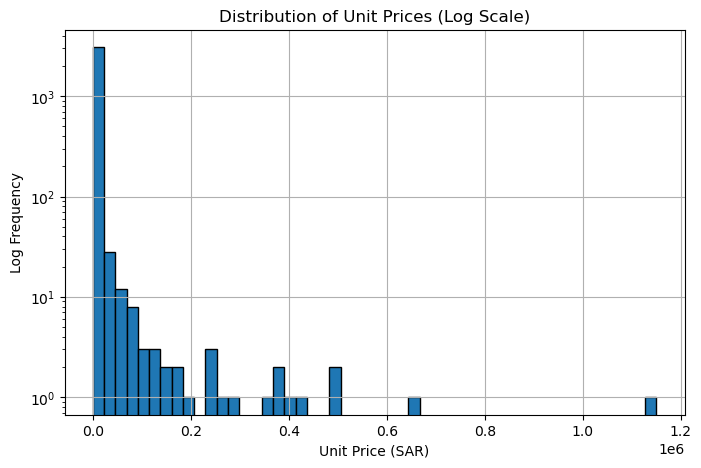

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
df["Unit Price"].hist(bins=50, edgecolor="black", log=True)
plt.xlabel("Unit Price (SAR)")
plt.ylabel("Log Frequency")
plt.title("Distribution of Unit Prices (Log Scale)")
plt.show()


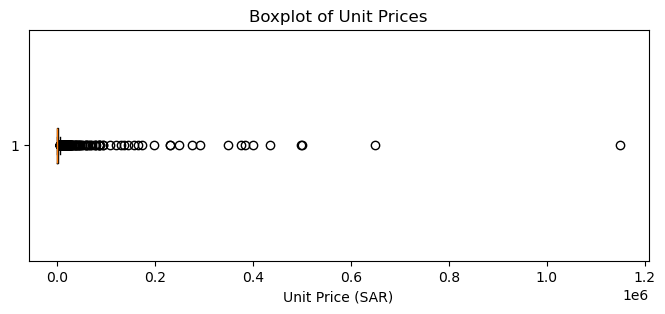

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.boxplot(df["Unit Price"].dropna(), vert=False, showfliers=True)
plt.xlabel("Unit Price (SAR)")
plt.title("Boxplot of Unit Prices")
plt.show()


In [84]:
# Top 10 highest unit prices

anomalies_high = df.sort_values("Unit Price", ascending=False).head(10)
anomalies_high[["Item Name", "Quantity", "Total Spend in SAR", "Unit Price"]]


,Item Name,Quantity,Total Spend in SAR,Unit Price
1347,خرسانة جاهزة,1.00,1150000.00,1.150000e+06
1606,حديد مقاسات مختلفة,1.00,650000.00,6.500000e+05
1231,اعمال تركيب الهناجر (50% من تصنيع وتركيب الهيك...,1.00,500000.00,5.000000e+05
1014,حديد قطاعات (كيربي),1.00,499000.00,4.990000e+05
2653,مواد كسارة,1.00,434782.61,4.347826e+05
1515,خرسانة جاهزة,1.00,400000.00,4.000000e+05
2168,4X240 CU/XLPE/SWA/PVC,0.59,226908.00,3.845898e+05
1877,حديد مقاسات مختلفة,1.00,375000.00,3.750000e+05
1348,ساندوتش بانل,1.00,350000.00,3.500000e+05
2841,Ready mix concrete,1.00,291335.99,2.913360e+05


---
## Step 7: Imputation of Missing Values

To retain as much relevant data as possible for spend analysis, I decided to fill missing values with contextually meaningful substitutes rather than dropping those rows. This approach ensures that potentially valuable records remain in the dataset and continue contributing to overall spend insights.


In [85]:
df.isna().sum()

Item ID                 0
Item Name             240
Quantity                0
Total Bcy               0
Purchase Order ID       0
Product ID            240
Currency Code           0
Account ID              0
Total Spend in SAR      0
Unit Price              0
dtype: int64

In [86]:
# Fill missing values with "Unknown Item" (so rows are not lost).

df["Item Name"] = df["Item Name"].fillna("Unknown Item")

In [87]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Total Spend in SAR,Unit Price
0,3263831000000089042,Unknown Item,75.21,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,227510.25,3025.0
1,3263831000000089046,Unknown Item,15.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,47250.00,3150.0
2,3263831000000089044,Unknown Item,50.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,160000.00,3200.0
3,3263831000000092044,Unknown Item,12.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,38280.00,3190.0
4,3263831000000092052,Unknown Item,2.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,5900.00,2950.0


---
## Step 8: Dropping Product ID

I decided to drop the `Product ID` column since it's just an identifier and doesn’t add value for clustering or spend analysis.


In [88]:
df = df.drop(columns=["Product ID"])

In [89]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Purchase Order ID,Currency Code,Account ID,Total Spend in SAR,Unit Price
0,3263831000000089042,Unknown Item,75.21,227510.25,3263831000000089040,SAR,3263831000000034003,227510.25,3025.0
1,3263831000000089046,Unknown Item,15.00,47250.00,3263831000000089040,SAR,3263831000000034003,47250.00,3150.0
2,3263831000000089044,Unknown Item,50.00,160000.00,3263831000000089040,SAR,3263831000000034003,160000.00,3200.0
3,3263831000000092044,Unknown Item,12.00,38280.00,3263831000000092040,SAR,3263831000000034003,38280.00,3190.0
4,3263831000000092052,Unknown Item,2.00,5900.00,3263831000000092040,SAR,3263831000000034003,5900.00,2950.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Item ID             3150 non-null   int64  
 1   Item Name           3150 non-null   object 
 2   Quantity            3150 non-null   float64
 3   Total Bcy           3150 non-null   float64
 4   Purchase Order ID   3150 non-null   int64  
 5   Currency Code       3150 non-null   object 
 6   Account ID          3150 non-null   int64  
 7   Total Spend in SAR  3150 non-null   float64
 8   Unit Price          3150 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 221.6+ KB


---
## Step 9: Text Column Type Conversion

I converted text-based columns (`Item Name`, `clean_item`, `Currency Code`) to `string` dtype instead of leaving them as `object`. This makes text operations like cleaning and regex more reliable, and also improves how missing values are handled—using `<NA>` instead of `NaN`.

It’s a small change, but it helps keep things consistent and easier to work with throughout the pipeline.


In [91]:
# 1) Cast IDs to string to avoid scientific notation/precision issues
id_cols = ["Item ID", "Purchase Order ID", "Account ID"]
for c in id_cols:
    df[c] = df[c].astype(str)

# 2) Ensure text columns are strings
text_cols = ["Item Name"]
for c in text_cols:
    df[c] = df[c].astype("string")  # pandas StringDtype (nicer than plain object)

# 3) Ensure numeric columns are floats
num_cols = ["Quantity", "Total Bcy", "Total Spend in SAR", "Unit Price"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")

# 4) Make Currency Code categorical (few distinct values)
df["Currency Code"] = df["Currency Code"].astype("category")

# 5) Quick sanity checks
assert (df["Quantity"] >= 0).all(), "Negative quantities found"
assert (df["Total Spend in SAR"] >= 0).all(), "Negative spend found"

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Item ID             3150 non-null   object  
 1   Item Name           3150 non-null   string  
 2   Quantity            3150 non-null   float64 
 3   Total Bcy           3150 non-null   float64 
 4   Purchase Order ID   3150 non-null   object  
 5   Currency Code       3150 non-null   category
 6   Account ID          3150 non-null   object  
 7   Total Spend in SAR  3150 non-null   float64 
 8   Unit Price          3150 non-null   float64 
dtypes: category(1), float64(4), object(3), string(1)
memory usage: 200.2+ KB


In [92]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Purchase Order ID,Currency Code,Account ID,Total Spend in SAR,Unit Price
0,3263831000000089042,Unknown Item,75.21,227510.25,3263831000000089040,SAR,3263831000000034003,227510.25,3025.0
1,3263831000000089046,Unknown Item,15.00,47250.00,3263831000000089040,SAR,3263831000000034003,47250.00,3150.0
2,3263831000000089044,Unknown Item,50.00,160000.00,3263831000000089040,SAR,3263831000000034003,160000.00,3200.0
3,3263831000000092044,Unknown Item,12.00,38280.00,3263831000000092040,SAR,3263831000000034003,38280.00,3190.0
4,3263831000000092052,Unknown Item,2.00,5900.00,3263831000000092040,SAR,3263831000000034003,5900.00,2950.0


## Step 10: Text Cleaning and Normalization

I decided to clean and standardize the text fields to improve consistency and prepare the data for reliable analysis and clustering. Here's the breakdown of the steps I applied:

1. Convert all text to lowercase  
   *(ensures uniformity and avoids case-sensitive mismatches)*

2. Remove Arabic diacritics (harakat) and tatweel (ــ)  
   *(cleans visual noise and improves token matching in Arabic text)*

3. Normalize Arabic letters  
   *(standardizes variations like "أ" vs "ا" to improve grouping and searchability)*

4. Convert Arabic-Indic digits to Western digits  
   *(ensures numeric consistency across languages for calculations and comparisons)*

5. Remove special characters  
   *(keeps only relevant symbols—English letters, digits, Arabic letters, spaces, and decimal dots—to reduce noise)*

6. Clean edge cases like leading/trailing dots (e.g., ".mm")  
   *(removes formatting artifacts that could interfere with parsing or clustering)*

These steps help ensure that the text data is clean, consistent, and ready for semantic analysis or feature extraction.


In [93]:
import re

def normalize_text(text):
    if not isinstance(text, str):
        return text
    
    # 1. Lowercase everything
    text = text.lower()
    
    # 2. Remove Arabic diacritics (harakat) & tatweel (ــ)
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652]")
    text = re.sub(arabic_diacritics, "", text)
    text = re.sub(r"ـ", "", text)  
    
    # 3. Normalize Arabic letters
    text = re.sub("[إأآا]", "ا", text)   # normalize alef forms
    text = re.sub("ى", "ي", text)       # alef maqsoora → ya
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)       # taa marbouta → haa
    
    # 4. Convert Arabic-Indic digits → Western digits
    arabic_num_map = {"٠":"0","١":"1","٢":"2","٣":"3","٤":"4",
                      "٥":"5","٦":"6","٧":"7","٨":"8","٩":"9"}
    for k,v in arabic_num_map.items():
        text = text.replace(k, v)
    
    # 5. Remove special characters (Keep English letters, digits, Arabic letters, spaces, and decimal dots inside numbers)
 
    text = re.sub(r"[^a-z0-9\u0600-\u06FF\s\.]", " ", text)
    
    # 6. Collapse cases where dot is at start/end (like ".mm") → remove extra dots
    text = re.sub(r"\s*\.0\s*", " ", text)  # ensures "12 . 0" → "12"
    
    return text


In [94]:
df["Clean Item Name"] = df["Item Name"].apply(normalize_text)

In [95]:
df[["Item Name", "Clean Item Name"]].tail(20)

,Item Name,Clean Item Name
3130,12.0 mm Black Deformed Straight Bar G60-12 M -...,12 mm black deformed straight bar g60 12 m sabic
3131,14.0 mm Black Deformed Straight Bar G60-12 M-S...,14 mm black deformed straight bar g60 12 m sabic
3132,25.0 mm Black Deformed Straight Bar G60 - 12 M...,25 mm black deformed straight bar g60 12 m s...
3133,18.0 mm Black Deformed Straight Bar G60-12 M -...,18 mm black deformed straight bar g60 12 m sabic
3134,12.0 mm Black Deformed Straight Bar G60 – 12M ...,12 mm black deformed straight bar g60 12m ...
3135,14.0 mm Black Deformed Straight Bar G60 – 12M ...,14 mm black deformed straight bar g60 12m ...
3136,12.0 MM Black deformed straight bar G60-12m-It...,12 mm black deformed straight bar g60 12m ittifaq
3137,حديد تسليح سعودي سابك 12 مم * 12م,حديد تسليح سعودي سابك 12 مم 12م
3138,حديد تسليح سعودي سابك 12 مم * 12م,حديد تسليح سعودي سابك 12 مم 12م
3139,حديد تسليح سعودي سابك 14 مم * 12 م,حديد تسليح سعودي سابك 14 مم 12 م


In [96]:
# Save to Excel
df.to_excel("purchase_orders_cleaned.xlsx", index=False)

print("✅ Data saved successfully")

✅ Data saved successfully
